# 시계열 데이터확인
## 1. 작업 준비
#### 패키지 및 데이터 가져오기
- 시계열 분석시 주의사항:
    - 인덱스가 시간 혹은 날짜로 설정되어 있는지 확인 필요
    - 결측치 및 이상치의 여부 확인 필요

In [27]:
from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
# import statsmodels.api as sm   # plot_acf랑 plot_pacf를 subplot에 넣기 위한 모듈
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sb
import sys

In [5]:
df = read_excel('https://data.hossam.kr/E06/air_passengers.xlsx',
                index_col='Month')
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


#### 그래프 초기화

In [8]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## 2. 데이터 살펴보기
### 1) 기초 통계량

In [9]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### 2) 결측치 확인

In [10]:
df['Passengers'].isna().sum()

0

> 결측치 없음 확인

### 3) 이상치 확인 (상자그림 사용)
-  `seaborn.boxplot()`

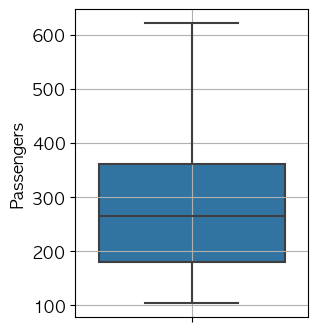

In [13]:
plt.figure(figsize = (3, 4))
sb.boxplot(data = df, y = 'Passengers')
plt.grid()
plt.show()
plt.close()

> 이상치 없음 확인

### 4) 기본 형태의 시계열 그래프를 통한 정상성 확인

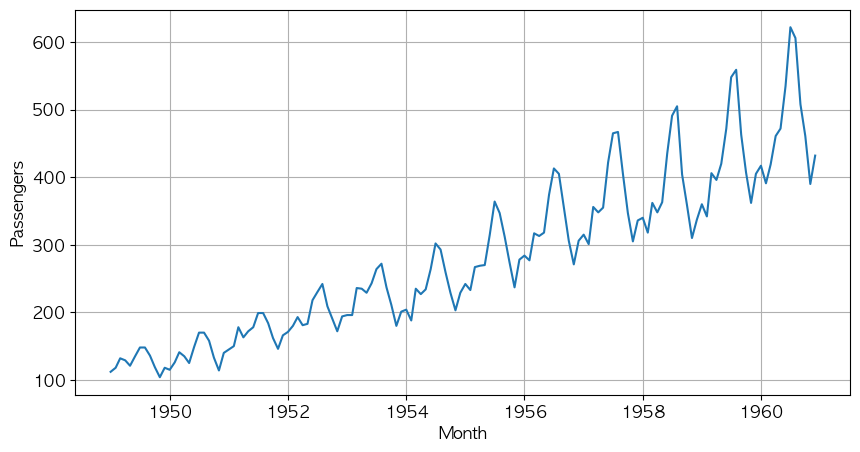

In [14]:
plt.figure()
sb.lineplot(df, x=df.index, y='Passengers')
plt.grid()
plt.show()
plt.close()

> 데이터의 패턴은 보이지만 `비정상성`임을 알 수 있다.

### 5) ADF 검증/테스트
- `adfuller(컬럼명)`
- 시계열 데이터의 `정상성 여부를 판단`하기 위함 검정
#### ADF 테스트의 가설

|가설|내용|
|--|--|
|귀무가설|데이터가 정상성과 다르다(=비정상성임을 의미)|
|대립가설|데이터가 정상성이다|

- 여기서 우리가 봐야할 것은 `p-value`이다
    - `p-value` > 0.05: `비정상성 데이터`로 간주 -> `차분을 1회 수행`하고 다시 ADF 검정을 수행
        - 대립가설이 채택될 때까지 이 과정을 반복함
        - `반복 횟수`(차분 한 횟수)가 $d$ 값이 됨
    - `p-value` < 0.05: `정상성 데이터`로 간주 -> 차분을 더 수행하지 않아도 됨

In [16]:
ar = adfuller(df['Passengers'])
print(ar)
print('검정통계량(ADF Statistic): %f' % ar[0])
print('유의수준(p-value): %f' % ar[1])
print('최적차수(num of lags): %f' % ar[2])
print('관측치 개수(num of observations): %f' % ar[3])
print('기각값(Critical Values):')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

print('데이터 정상성 여부: ', '정상' if ar[1] < 0.05 else '비정상')

(0.8153688792060447, 0.9918802434376409, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)
검정통계량(ADF Statistic): 0.815369
유의수준(p-value): 0.991880
최적차수(num of lags): 13.000000
관측치 개수(num of observations): 130.000000
기각값(Critical Values):
	1%: -3.482
	5%: -2.884
	10%: -2.579
데이터 정상성 여부:  비정상


## 3. `평균 이동법`을 통한 시계열 데이터 분석
- 가장 고전적인 시계열 데이터 분석 방법
- 주어진 구간의 평균을 구해서 이어서 표시하는 방법으로 미래의 데이터 예측
- 평균 이동 결과가 실제 데이터와 얼마나 차이가 나는지의 여부로 데이터를 판단
- 과거로부터 현재까지의 시계열 자료를 대상으로 일정기간별 평균이동을 계산하면 이들의 추세를 통해 다음 기간 예측 가능
> 평균이동 시각화의 목적은 데이터가 정상성을 만족하는지 확인하여 차분 적용 여부를 결정하기 위함(거의 99% 이상이 비정상성)
### 1) 단순 이동평균 (SMA, Simple Moving Average)
- 가장 많이 사용하는 방식
- `컬럼.rolling(n).mean()`
    - `.rolling(n)` -> n개씩 묶는다는 개념
#### 3개월, 6개월, 9개월 단위 평균

            Passengers        sma3  ...        ewm6        ewm9
Month                               ...                        
1949-01-01         112         NaN  ...  112.000000  112.000000
1949-02-01         118         NaN  ...  115.230769  115.157895
1949-03-01         132  120.666667  ...  121.700787  121.372694
1949-04-01         129  126.333333  ...  123.966516  123.590579
1949-05-01         121  127.333333  ...  123.177832  122.957974
...                ...         ...  ...         ...         ...
1960-08-01         606  587.666667  ...  490.264766  468.874660
1960-09-01         508  578.666667  ...  492.798371  472.787195
1960-10-01         461  525.000000  ...  488.255746  471.608475
1960-11-01         390  453.000000  ...  474.219211  463.447626
1960-12-01         432  427.666667  ...  468.187895  460.302862

[144 rows x 7 columns]


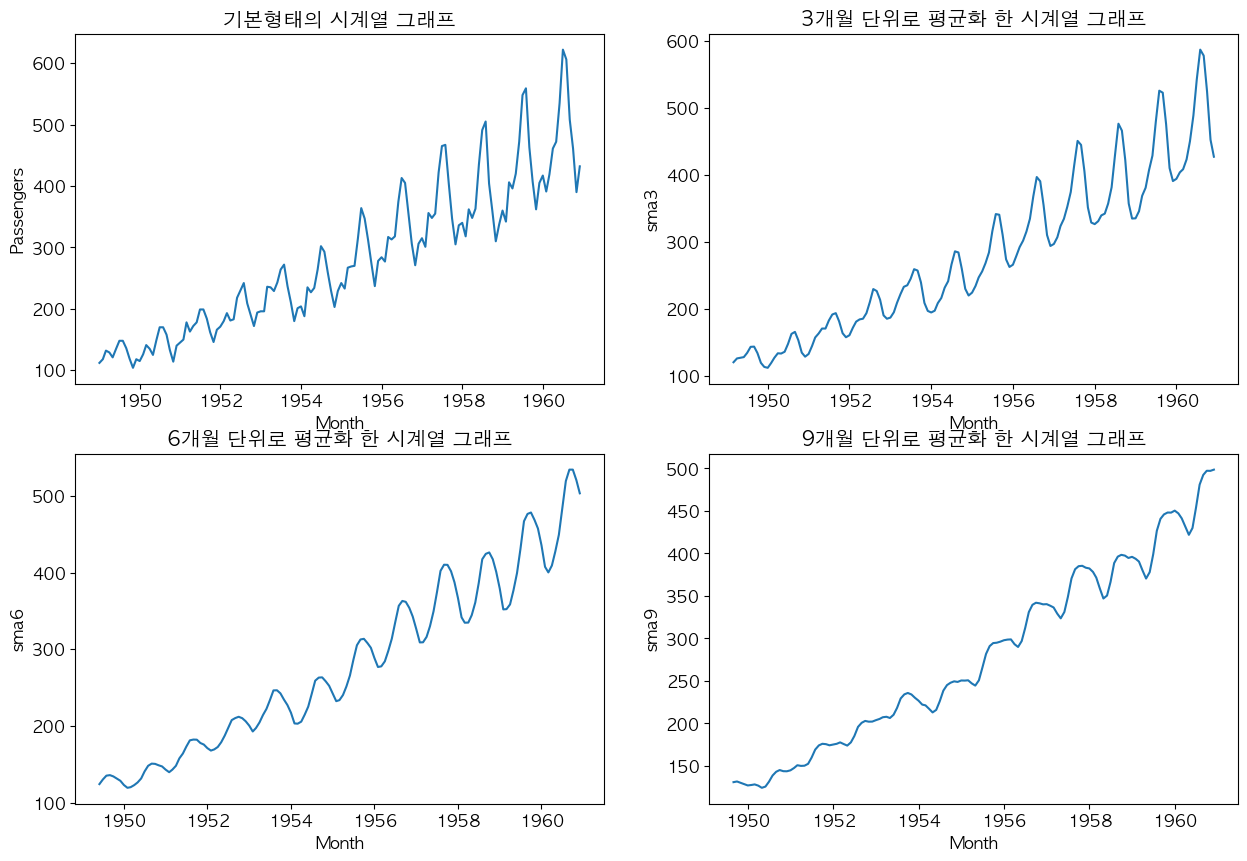

In [20]:
df['sma3'] = df['Passengers'].rolling(3).mean()
df['sma6'] = df['Passengers'].rolling(6).mean()
df['sma9'] = df['Passengers'].rolling(9).mean()
print(df)

# 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(15,10))
sb.lineplot(df, x=df.index, y='Passengers', ax=ax1)
ax1.set_title('기본형태의 시계열 그래프')
sb.lineplot(df, x=df.index, y='sma3', ax=ax2)
ax2.set_title('3개월 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='sma6', ax=ax3)
ax3.set_title('6개월 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='sma9', ax=ax4)
ax4.set_title('9개월 단위로 평균화 한 시계열 그래프')
plt.show()
plt.close()

### 2) 지수 이동평균 (EMA, Exponential Moving Average)
- 보다 최근의 값에 가중치를 두면서 이동평균을 계산하는 방법
- `컬럼.ewm(n).mean()`
    - `ewm(n)` -> n개씩 묶는다는 개념
#### 3개월, 6개월, 9개월 단위 평균

            Passengers        sma3  ...        ewm6        ewm9
Month                               ...                        
1949-01-01         112         NaN  ...  112.000000  112.000000
1949-02-01         118         NaN  ...  115.230769  115.157895
1949-03-01         132  120.666667  ...  121.700787  121.372694
1949-04-01         129  126.333333  ...  123.966516  123.590579
1949-05-01         121  127.333333  ...  123.177832  122.957974
...                ...         ...  ...         ...         ...
1960-08-01         606  587.666667  ...  490.264766  468.874660
1960-09-01         508  578.666667  ...  492.798371  472.787195
1960-10-01         461  525.000000  ...  488.255746  471.608475
1960-11-01         390  453.000000  ...  474.219211  463.447626
1960-12-01         432  427.666667  ...  468.187895  460.302862

[144 rows x 7 columns]


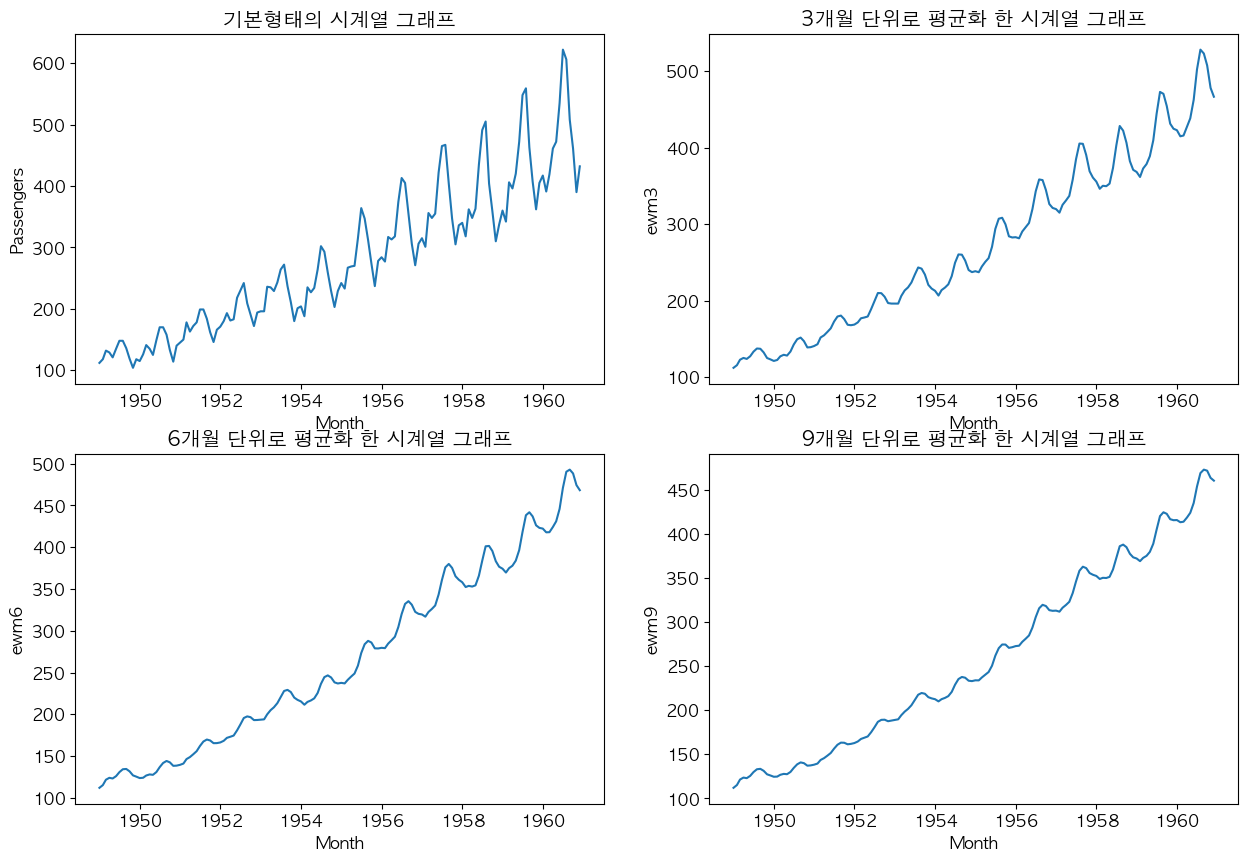

In [23]:
df['ewm3'] = df['Passengers'].ewm(3).mean()
df['ewm6'] = df['Passengers'].ewm(6).mean()
df['ewm9'] = df['Passengers'].ewm(9).mean()
print(df)

# 시각화
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2,
                                            ncols=2,
                                            figsize=(15, 10))
sb.lineplot(df, x=df.index, y='Passengers', ax=ax1)
ax1.set_title('기본형태의 시계열 그래프')
sb.lineplot(df, x=df.index, y='ewm3', ax=ax2)
ax2.set_title('3개월 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='ewm6', ax=ax3)
ax3.set_title('6개월 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='ewm9', ax=ax4)
ax4.set_title('9개월 단위로 평균화 한 시계열 그래프')
plt.show()
plt.close()

## 4. ACF, PACF 검정
- 정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)에 접근한다.
- 비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.
> 차분이 필요 없다고 판정되었으므로 원본 데이터로 진행

|구분|$AR(p)$ 모델 적합|$MA(q)$ 모델 적합|
|--|--|--|
|ACF plot|천천히 감소|첫 값으로부터 $q$개 뒤에 끊긴다|
|PACF plot|첫 값으로부터 $p$개 뒤에 끊긴다|천천히 감소|

### 1) ACF Plot & PACF Plot
- `plot_acf(컬럼)`
- `plot_pacf(컬럼)`

- subplot에 담기 위한 함수: 
    - `statsmodels.api.graphics.tsa.plot_acf()`
    - `statsmodels.api.graphics.tsa.plot_pacf()`
- ACF, PACF Plot으로 적용할 모델을 결정하려면 차분을 몇 번 수행하는 것이 좋을지 결정해야 함

|모델|의미|
|--|--|
|$AR(n)$|$ARIMA(p, d, q)$ 중에서 $p=n, q=0$ 이라는 의미|
|$MA(n)$|$ARIMA(p, d, q)$ 중에서 $p=0, q=n$ 이라는 의미|

- ADF 테스트의 결과로 `차분의 횟수`가 결정되면 이 값이 `d`를 의미함

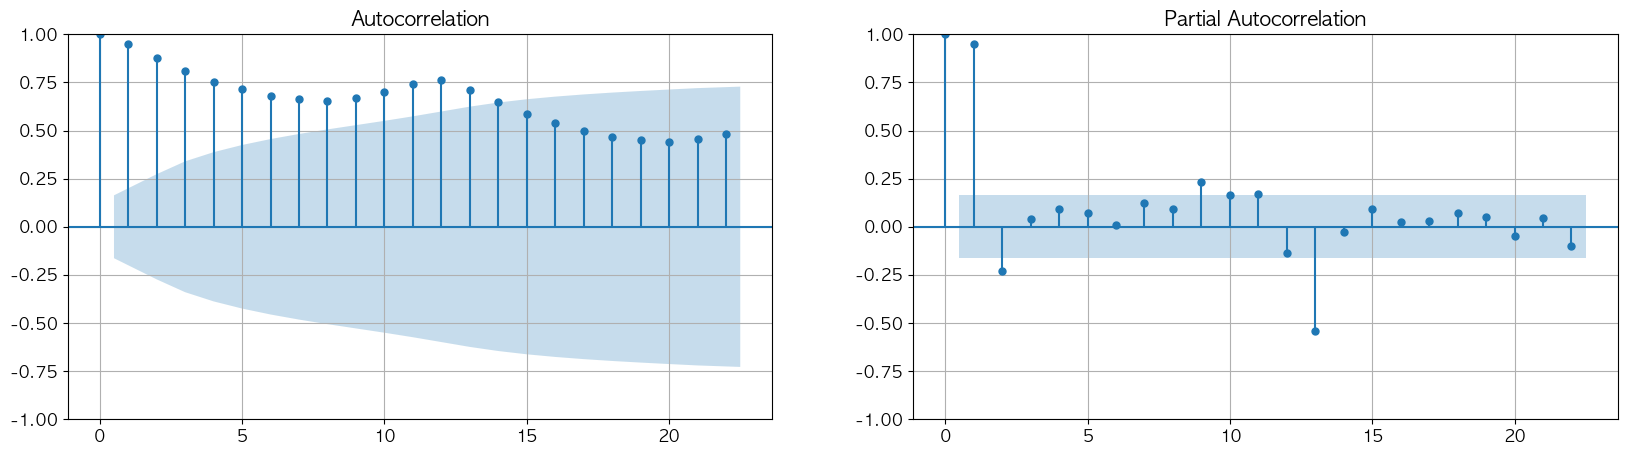

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(20, 5))
# sm.graphics.tsa.plot_acf(df['Passengers'], ax=ax1)    # ACF Plot
# sm.graphics.tsa.plot_pacf(df['Passengers'], ax=ax2)   # PACF Plot
plot_acf(df['Passengers'], ax=ax1)
plot_pacf(df['Passengers'], ax=ax2)
ax1.grid()
ax2.grid()
plt.show()
plt.close()


#### 결과 판정
> |구분|ACF plot|PACF plot|
> |--|--|--|
> |감소|상대적으로 완만|상대적으로 급격|
> |파란박스 진입 지점|$p = 1$|$q = 1$|
>
> 이 결과를 고려하여 완만함을 보이는 `ACF 플롯` 채택, `AR(1) 모델`로 결정
- 완만하다는 기준: 동그라미들이 거의 일직선으로 가면 "완만하다"고 말함

## 5. 시계열 분해
- 시계열 자료를 `추세(Trend)`, `계절성(Seasonal)`, `잔차(Rasidual)`로 분해하는 데이터 전처리 방법

|구분|설명|
|--|--|
|가법모델(Additive Model)|시계열 데이터를 구성하는 각 성분이 덧셈을 통해 연결되어 있다고 가정|
|승법모델(Multiplicative Model)|각 성분이 곱셈을 통해 연결되어 있다고 가정;승법 모델은 로그 변환을 통해 가법 모델로 쉽게 변환 가능|
- 모델 선택은 시계열 데이터의 특성을 고려하면 되는데, 아래 그림의 왼편 그래프와 같이 시간에 따른 데이터 변동이 일정한 경우는 가법 모델을 활용한 데이터 분해가 적합

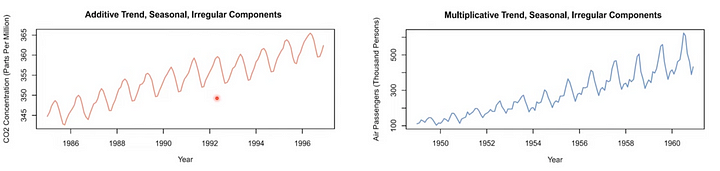

In [29]:
from IPython.display import Image, display
display(Image(filename='timeseries4.png'))

### 1) 모델 적용한 시계열 분해 및 분석 결과 시각화 (자동구현)
- 가법 모델(Additive Model)
    - `seasonal_decompose(컬럼명, model = 'additive')`
    - trend와 seasonal이 별개임
- 승법 모델(Multiplicative Model)
    - `seasonal_decompose(컬럼명, model = 'multiplicative')`
    - 이 모델 활용 시 데이터에 0이 존재해서는 안 됨
    - trend에 따라 seasonal이 변화함
- 자동 구현 시각화
    - `.get_children()`

              관측값  트랜드       계절성  잔차
Month                               
1949-01-01  112.0  NaN  0.910230 NaN
1949-02-01  118.0  NaN  0.883625 NaN
1949-03-01  132.0  NaN  1.007366 NaN
1949-04-01  129.0  NaN  0.975906 NaN
1949-05-01  121.0  NaN  0.981378 NaN
...           ...  ...       ...  ..
1960-08-01  606.0  NaN  1.219911 NaN
1960-09-01  508.0  NaN  1.060492 NaN
1960-10-01  461.0  NaN  0.921757 NaN
1960-11-01  390.0  NaN  0.801178 NaN
1960-12-01  432.0  NaN  0.898824 NaN

[144 rows x 4 columns]


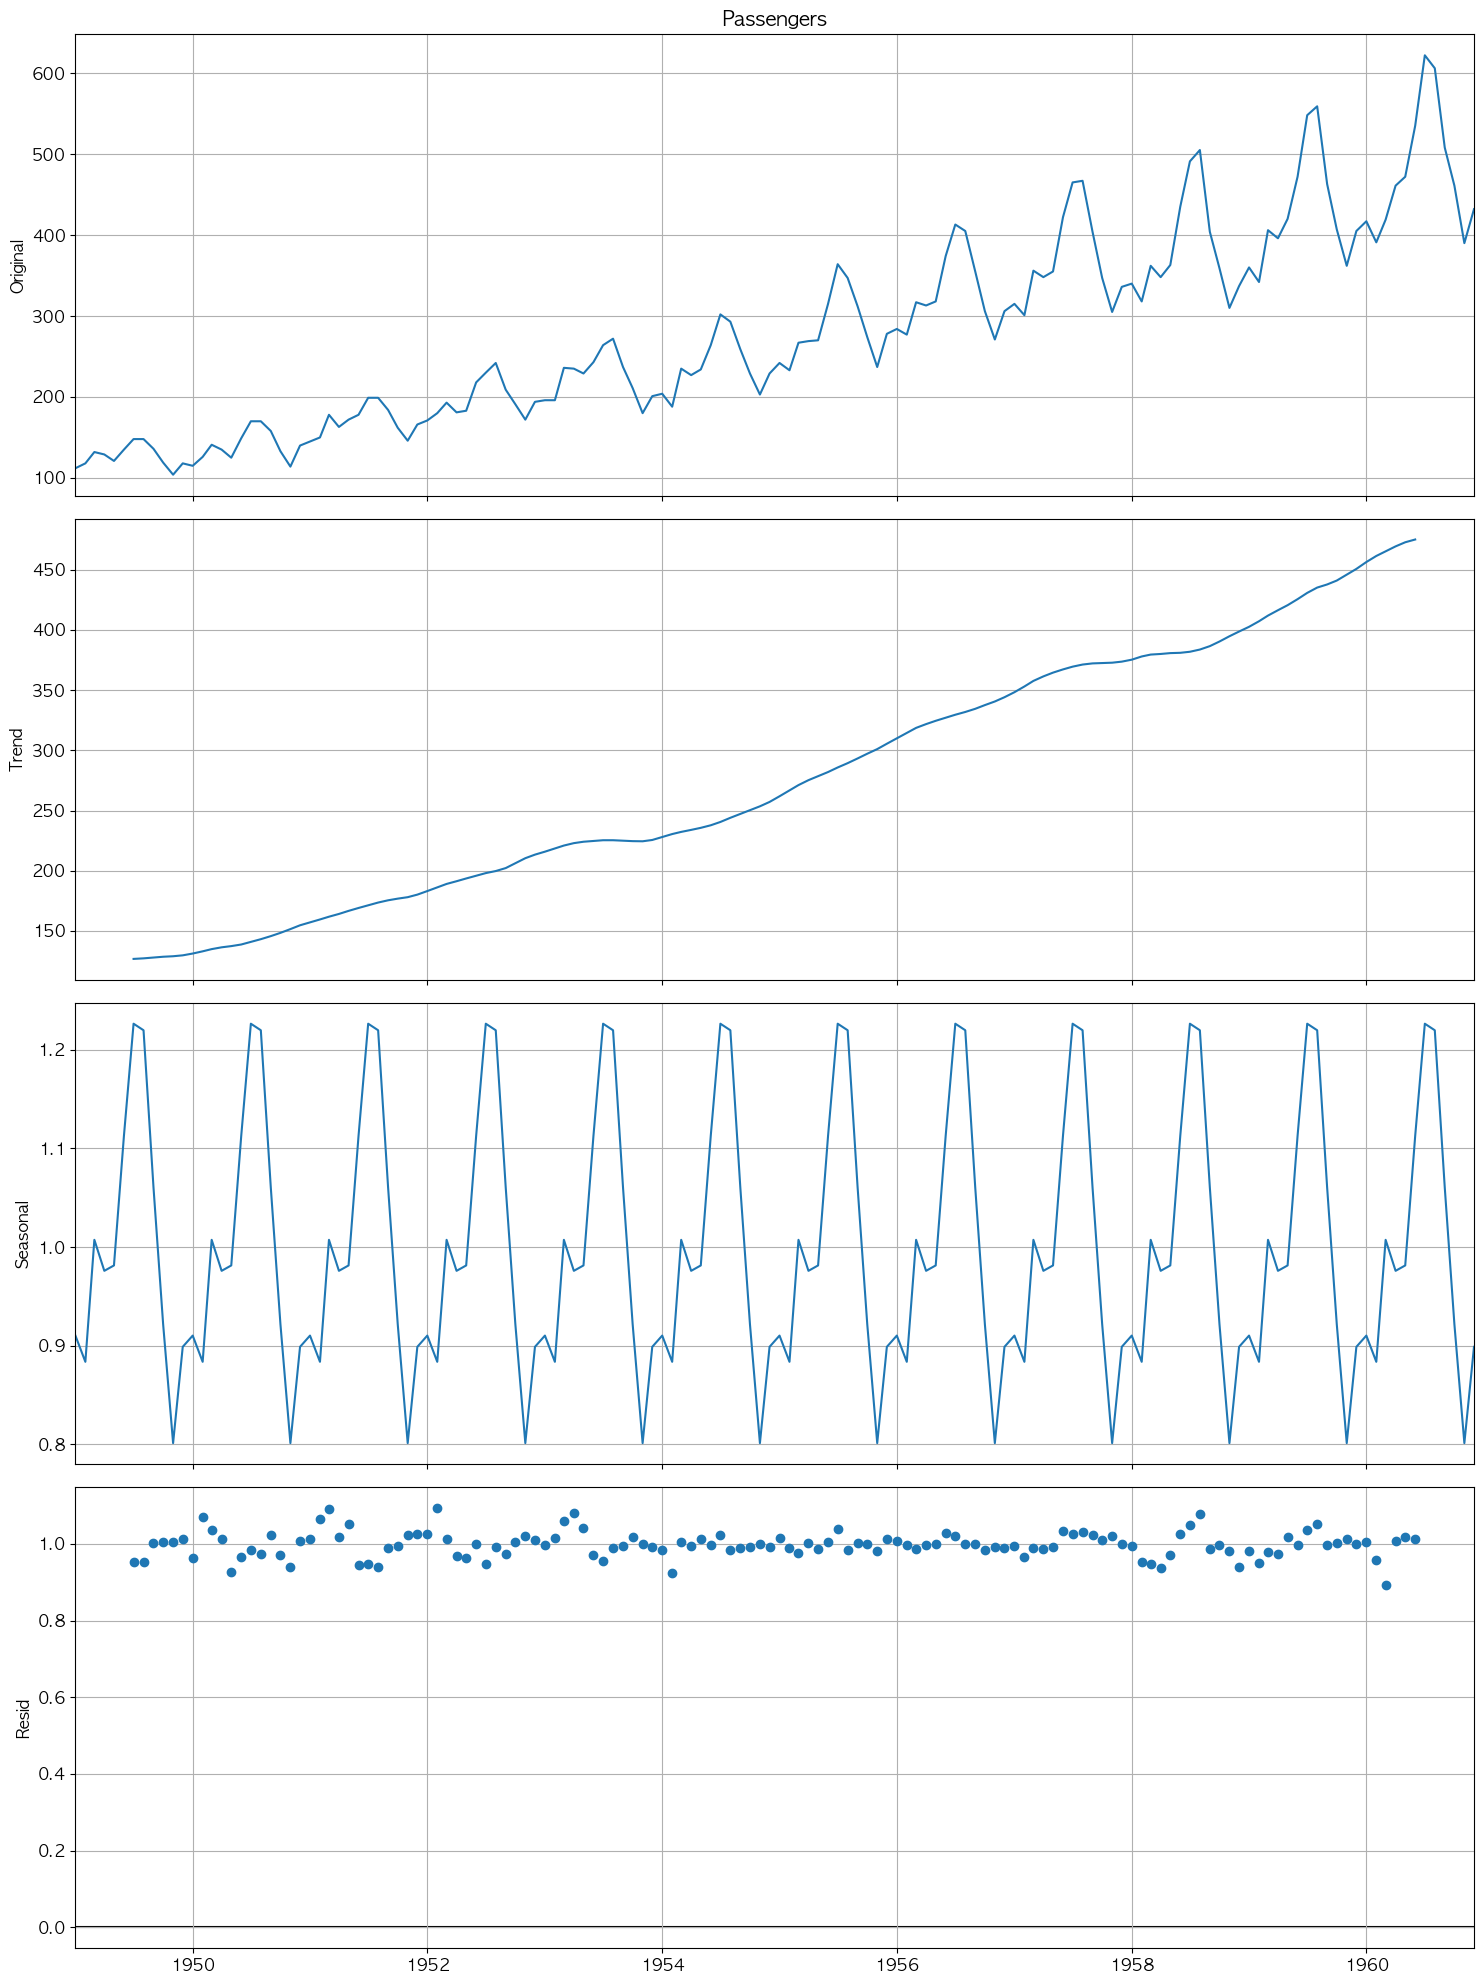

In [34]:
# model_name = 'additive'           # 가법 모델
model_name = 'multiplicative'       # 승법 모델

sd = seasonal_decompose(df['Passengers'], model=model_name)

# trend, seasonal, residual 데이터프레임으로 변환
sd_df = DataFrame({
    '관측값': sd.observed,
    '트랜드': sd.trend,
    '계절성': sd.seasonal,
    '잔차': sd.resid
}, index = df.index)
print(sd_df)

# 분석결과 시각화 (자동 구현)
plt.rcParams['figure.figsize']=(15, 20)
figure = sd.plot()
fig, ax1, ax2, ax3, ax4 = figure.get_children()

ax1.set_ylabel('Original')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

plt.show()
plt.close()

###